In [1]:
import os

# Set the working directory to a specific path
os.chdir("C:/Users/ethan/OneDrive/Desktop/CW Programming/dataverse_files")

In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
# Load carriers and airports data
carriers = pd.read_csv("carriers.csv")
airports = pd.read_csv("airports.csv")

In [4]:
# Function to process data and fit logistic regression model
def fit_logistic_regression(year):
    # Load the data for the given year
    data = pd.read_csv(f"{year}.csv")
    
    # Merging with carriers and airports data
    data = data.merge(carriers, left_on="UniqueCarrier", right_on="Code", how='left')
    data = data.merge(airports.rename(columns={'iata': 'Origin', 'lat': 'lat_origin', 'long': 'long_origin'}), on="Origin", how='left')
    data = data.merge(airports.rename(columns={'iata': 'Dest', 'lat': 'lat_dest', 'long': 'long_dest'}), on="Dest", how='left')
    
    # Dummy variables
    carrier_dummies = pd.get_dummies(data['UniqueCarrier'], prefix='carrier', drop_first=True)
    data = pd.concat([data, carrier_dummies], axis=1)
    
    # Add a constant term for the intercept
    data['intercept'] = 1.0
    
    # Selecting relevant columns
    columns = ['intercept', 'Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'Distance', 'lat_origin', 'long_origin', 'lat_dest', 'long_dest'] + list(carrier_dummies.columns)
    
    # Dealing with missing rows
    data = data.dropna(subset=columns)
    
    # Fitting logistic regression model
    model = sm.Logit(data['Diverted'], data[columns])
    result = model.fit(disp=0)
    
    # Extracting the coefficients
    coeffs = pd.DataFrame({'term': result.params.index, 'estimate': result.params.values})
    coeffs['Year'] = year
    return coeffs

# Fit model over the years
coefficients_list = []
for year in range(1990, 2000):
    try:
        coeffs = fit_logistic_regression(year)
        coefficients_list.append(coeffs)
    except Exception as e:
        print(f"An error occurred for year {year}: {e}")

# Combine coefficients from all years into a single DataFrame
combined_coefficients = pd.concat(coefficients_list, ignore_index=True)

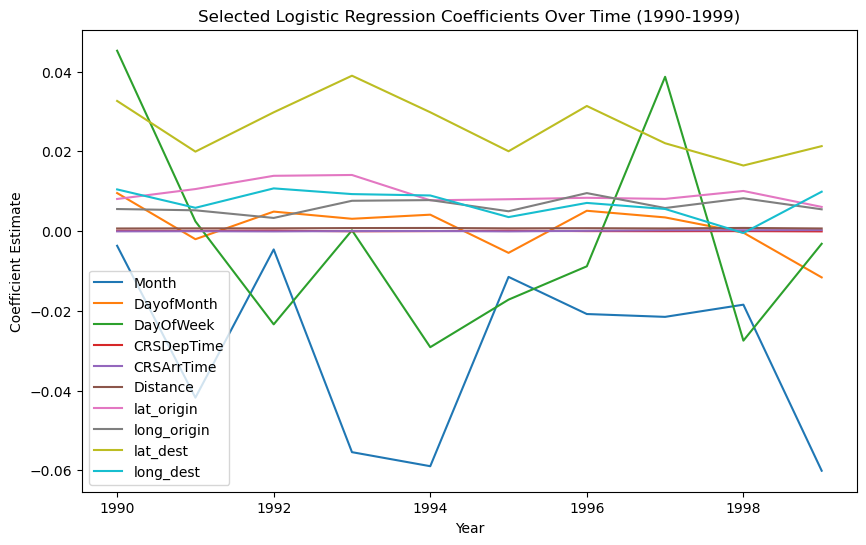

In [5]:
# First Plot: Filtered coefficients for the selected terms
relevant_terms = ['Month', 'DayofMonth', 'DayOfWeek', 'CRSDepTime', 'CRSArrTime', 'Distance', 'lat_origin', 'long_origin', 'lat_dest', 'long_dest']
filtered_coefficients = combined_coefficients[combined_coefficients['term'].isin(relevant_terms)]
plt.figure(figsize=(10, 6))
for term in relevant_terms:
    subset = filtered_coefficients[filtered_coefficients['term'] == term]
    plt.plot(subset['Year'], subset['estimate'], label=term)

plt.title("Selected Logistic Regression Coefficients Over Time (1990-1999)")
plt.xlabel("Year")
plt.ylabel("Coefficient Estimate")
plt.legend()
plt.show()


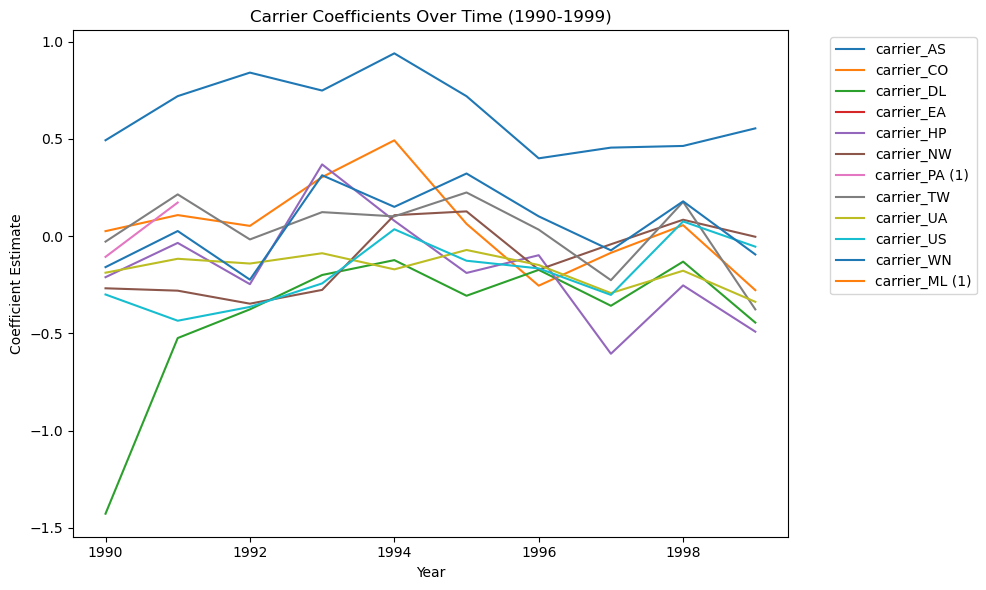

In [6]:
# Second Plot: Filtered coefficients for carriers
carrier_coefficients = combined_coefficients[combined_coefficients['term'].str.startswith('carrier_')]
plt.figure(figsize=(10, 6))
carrier_terms = carrier_coefficients['term'].unique()
for term in carrier_terms:
    subset = carrier_coefficients[carrier_coefficients['term'] == term]
    plt.plot(subset['Year'], subset['estimate'], label=term)

plt.title("Carrier Coefficients Over Time (1990-1999)")
plt.xlabel("Year")
plt.ylabel("Coefficient Estimate")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()